In [1]:
import pandas as pd
import PIL
from PIL import Image
import torch
from torch import nn, optim
import numpy as np

/home/pedro/anaconda3/envs/dc_claas/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
instruments = pd.read_csv('music_data_img.csv').iloc[:,1:]

In [3]:
instruments.columns

Index(['Instrument_Type', 'Image_File'], dtype='object')

In [4]:
instruments['Instrument_Type'].value_counts()

Studio / Live Music Equipment    1142
String Instrument / Amplifier    1089
Keyboard / Piano                  418
Percussion / drums                393
Other Instrument                  104
Woodwind / brass                   45
Sheet Music                        30
Vinyl                              23
Name: Instrument_Type, dtype: int64

In [5]:
non_existant = []
images = {'Instrument':[],'Image':[]}
for i, v in zip(instruments['Image_File'],instruments['Instrument_Type']):
    try:
        images['Image'].append(Image.open(i))
        images['Instrument'].append(v)
    except:
        pass

In [6]:
images['Image'][0].size

(160, 120)

In [7]:
tamanhos_imagens = set()
for i in images['Image']:
    tamanhos_imagens.add(i.size)

In [8]:
tamanhos_imagens

{(142, 107), (160, 120)}

## Now it is important to resize the images, or else we won't be able to fit them into a tensor

### Example

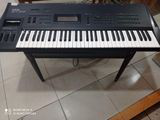

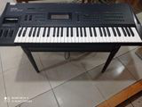

In [9]:
antes = []
depois = []
for i in images['Image']:
    if i.size == (160,120):
        depois.append(i.resize(size=(142, 107)))
        antes.append(i) 
display(antes[0],depois[0])

# Fitting it back to a DataFrame, but as a numpy array

In [10]:
for index, image in enumerate(images['Image']):
    img = image.resize(size=(50, 50))
    images['Image'][index] = np.asarray(img)

In [11]:
images['Image'] = np.array(images['Image'])

In [12]:
images['Image'].shape

(3176, 50, 50, 3)

# Now we're already able to turn images to tensors and start using torch's neural networks on them!

In [13]:
target_encoder = {v: i for i,v in dict(enumerate(instruments['Instrument_Type'].unique())).items()}
for i, v in enumerate(images['Instrument']):
    images['Instrument'][i] = target_encoder[v]

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images['Image'], np.array(images['Instrument']), test_size=0.2)

In [15]:
from torch.utils.data import DataLoader
class Dataset(object):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index], self.y[index]

train_loader = DataLoader(Dataset(X_train, y_train), batch_size=30, shuffle=True)
test_loader = DataLoader(Dataset(X_test, y_test), batch_size=30, shuffle=True)

In [16]:
import torch.nn.functional as F
import math

class NeuralNetworking(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.flatten =  nn.Flatten()
        self.pool = nn.MaxPool2d(2, 2)
        self.convLayer1 = nn.Conv2d(3, 6, 7)
        self.convLayer2 = nn.Conv2d(6, 16, 5)              
        self.linear_layers = nn.Sequential(
                      nn.Linear(9*9*16,8*8),
                      nn.ReLU(),
                      nn.Linear(8*8,8*3),
                      nn.ReLU(),
                      nn.Linear(8*3,output_size)
                      )

    def forward(self, x):
        x = self.pool(F.relu(self.convLayer1(x)))
        x = self.pool(F.relu(self.convLayer2(x)))
        x = self.flatten(x)
        x = self.linear_layers(x)
        return x

In [17]:
model = NeuralNetworking(50*50*3,8)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(),lr=1e-3)

In [18]:
epochs = 20

for epoch in range(epochs):
    for i, (X, y) in enumerate(train_loader):
        y_pred = model(X.view(X.shape[0],3,50,50))
        optimizer.zero_grad()

        loss = criterion(y_pred, y.type(torch.long))
        loss.backward()
        optimizer.step()
        
        if i % 20 == 0 and (epoch+1) % 5 == 0:
            print(f'currently at epoch {epoch + 1} batch number {i} with loss {loss}')

currently at epoch 5 batch number 0 with loss 1.2016685009002686
currently at epoch 5 batch number 20 with loss 1.0501925945281982
currently at epoch 5 batch number 40 with loss 1.4296525716781616
currently at epoch 5 batch number 60 with loss 1.3390461206436157
currently at epoch 5 batch number 80 with loss 1.4339148998260498
currently at epoch 10 batch number 0 with loss 0.8383604288101196
currently at epoch 10 batch number 20 with loss 0.9876372814178467
currently at epoch 10 batch number 40 with loss 0.6655951142311096
currently at epoch 10 batch number 60 with loss 0.8170527219772339
currently at epoch 10 batch number 80 with loss 0.8280488848686218
currently at epoch 15 batch number 0 with loss 0.6214418411254883
currently at epoch 15 batch number 20 with loss 0.38969507813453674
currently at epoch 15 batch number 40 with loss 0.6004536151885986
currently at epoch 15 batch number 60 with loss 0.49343350529670715
currently at epoch 15 batch number 80 with loss 0.5141087770462036
c

In [19]:
got_it_right = {0:[0,0],1:[0,0],2:[0,0],3:[0,0],4:[0,0],5:[0,0],6:[0,0],7:[0,0]}
predict_list = []
total = 0
with torch.no_grad():
    for i, (X, y) in enumerate(test_loader):
        y_pred = model(X.view(X.shape[0],3,50,50))
        _, predictions = torch.max(y_pred,1)
        for actual, predicted in zip(y,predictions):
            got_it_right[int(actual)][1] +=1
            predict_list.append(int(predicted))
            if actual == predicted:
                got_it_right[int(actual)][0] +=1

encoder = {value:key for key,value in target_encoder.items()}

{encoder[i]:v[0]/v[1] for i, v in got_it_right.items()}

{'Keyboard / Piano': 0.3488372093023256,
 'Studio / Live Music Equipment': 0.5021834061135371,
 'String Instrument / Amplifier': 0.4511627906976744,
 'Percussion / drums': 0.09523809523809523,
 'Other Instrument': 0.13043478260869565,
 'Woodwind / brass': 0.125,
 'Sheet Music': 0.14285714285714285,
 'Vinyl': 0.0}